In [23]:
from gurobipy import GRB, Model
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [24]:
price_time_series = []

with open('elspot-prices_2019_hourly_eur.csv') as f:
    next(f)
    for r in f:
        r = r.strip()
        date, hour, price = r.split(';')
        hour = hour[:2]
        price = price.replace(',', '.')
        price_time_series.append((date, hour, price))
        
prices = [float(x[2]) for x in price_time_series if x[2]  != '']

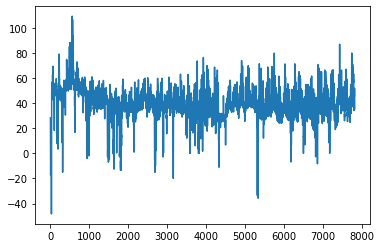

In [26]:
plt.plot(prices)
plt.savefig('Prices')

In [27]:
hours = range(len(prices))

In [29]:
pump_max = 70
turb_max = 90
effic = 0.75
# It is possible to run the turbine 7 hours non-stop if the storage is full
storage_capacity = 7 * 90

In [30]:
m = Model('pump storage')

In [31]:
pump = m.addVars(hours, vtype=GRB.BINARY, name='pump_var')

In [32]:
turb = m.addVars(hours, vtype=GRB.CONTINUOUS, lb=0, ub = turb_max)

In [33]:
storage_level = m.addVars(hours, vtype=GRB.CONTINUOUS, lb=0, ub=storage_capacity)

In [34]:
# Initial storage level
m.addConstr(storage_level[0] == 300)
# Final storage level
m.addConstr(storage_level[max(hours)] == 300)
m.update()

In [35]:
m.addConstrs(
    storage_level[t+1] == storage_level[t] + pump[t] * pump_max * effic - turb[t] for t in hours if t != max(hours)
)
m.update()

In [36]:
# Turbine and pump cannot run at the same time
m.addConstrs(
    (1-pump[t]) * turb_max >= turb[t] for t in hours
)
m.update()

In [37]:
m.setObjective(
    quicksum(
        (turb[t] - pump[t] * pump_max) * prices[t] for t in hours
    ), sense=GRB.MAXIMIZE
)

In [38]:
m.Params.TimeLimit = 120
m.optimize()

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 15649 rows, 23472 columns and 46942 nonzeros
Model fingerprint: 0x072daf43
Variable types: 15648 continuous, 7824 integer (7824 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [1e-02, 8e+03]
  Bounds range     [1e+00, 6e+02]
  RHS range        [9e+01, 3e+02]
Presolve removed 9 rows and 10 columns
Presolve time: 0.05s
Presolved: 15640 rows, 23462 columns, 46924 nonzeros
Variable types: 15639 continuous, 7823 integer (7823 binary)

Root relaxation: objective 1.630961e+06, 566 iterations, 0.62 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1630961.00    0   87          - 1630961.00      -     -    0s
H    0     0                    1627651.2250 1630961.00  0.20%

In [39]:
pump_prices = [prices[t] for t in hours if pump[t].X > 0.1]

In [40]:
turb_prices = [prices[t] for t in hours if turb[t].X > 0.1]

c:\users\sudermn\anaconda3\envs\dfrp\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\sudermn\anaconda3\envs\dfrp\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

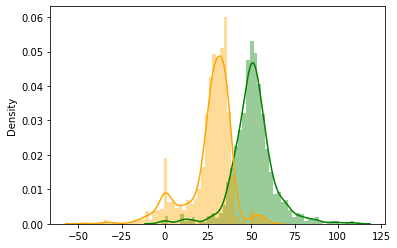

In [41]:
sns.distplot(turb_prices, color='green')
sns.distplot(pump_prices, color='orange')